# Experiments

### "Log Barriers for Safe Optimization of Smooth Constrained Problems" Usmanova et. al., Section 5.1

In [317]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [318]:
import os
import sys
sys.path.append('..')

import numpy as np
from numpy import linalg
from scipy.optimize import linprog, minimize_scalar
from scipy.stats import norm, chi2
from scipy.linalg import expm
from scipy.integrate import quad

import numdifftools as nd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
%matplotlib inline

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import lib.LB_optimizer as LB
from lib.functions_plots import plot_convergence_shaded, plot_experiments, read_LineBO, plot_experiments_linebo, plot_runtimes

from time import time

import matplotlib.patches as mpatches

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
import h5py

import pickle

In [319]:
import GPy
from safeopt import SafeOpt, SafeOptSwarm
from safeopt import linearly_spaced_combinations, plot_3d_gp
from lib.safeopt_run import run_SafeOpt

### Comparison experiments functions for SafeOpt and LB_SGD

In [320]:
def run_exp_SafeOpt(f, h, 
                    d, m,
                    experiments_num = 5, 
                    n_iters = 100,  
                    x00 = np.zeros(2), 
                    x_opt =  np.ones(2) / 2**0.5,  
                    sigma = 0.001,                # noise in measurements
                    bnd_l = -1., bnd_u = 1.,      # bounds of sampling for SafeOpt
                    problem_name = '',
                    gp_var = 0.1, gp_var_cons = None,
                    L = 0.25,  
                    gp_num_samples = 50, 
                    print_it = False, 
                    method = None):

    errors = []
    cons = []
    runtimes = []
    for i in range(experiments_num):
        time_0 = time()
        x_traj, errors_so, cons_so, gp = run_SafeOpt(n_iters, 
                                                     f, h, 
                                                     x00, x_opt, 
                                                     d, m, 
                                                     sigma, 
                                                     bnd_l, bnd_u, 
                                                     gp_var=gp_var,
                                                     gp_var_cons=gp_var_cons,
                                                     L=L,  
                                                     gp_num_samples=gp_num_samples,
                                                     print_it = print_it,
                                                    method = method)
        runtimes.append(time() - time_0)
        print("SafeOptRun finished")
        errors.append(errors_so)
        cons.append(cons_so)
    errors = np.array(errors)
    cons = np.array(cons)
    runtimes = np.array(runtimes)
    
    with open('../runs/SafeOpt_' + problem_name + '_d' + str(d)  + '.npy', 'wb') as file:
        np.save(file, errors)
        np.save(file, cons)
        np.save(file, runtimes)
    
    return (errors, cons, gp)  

def run_exp_LB_SGD(f, h, d, m,
                   experiments_num = 5, 
                   n_iters = 100, 
                   n = 1, 
                   M0 = 0.5 / 2., 
                   Ms = 0. * np.ones(4), 
                   x00 = np.zeros(2), 
                   x_opt =  np.ones(2) / 2**0.5, 
                   sigma = 0.001, nu = 0.01, 
                   eta0 = 0.05, 
                   T = 3, 
                   factor = 0.85, 
                   init_std = 0.1,
                   problem_name = ''):

    my_oracle = LB.Oracle(
        f = f,
        h = h, 
        sigma = sigma,
        hat_sigma = 0.01,
        delta = 0.01,
        m = m,
        d = d,
        nu = nu,
        zeroth_order = True,
        n = n)

    opt = LB.SafeLogBarrierOptimizer(
        x00 = x00,
        x0 = x00,
        M0 = M0,
        Ms = Ms,
        sigma = my_oracle.sigma,
        hat_sigma = my_oracle.hat_sigma,
        init_std = init_std,
        eta0 = eta0,
        oracle = my_oracle,
        f = f,
        h = h,
        d = d,
        m = m,
        reg = 0.0001,
        x_opt = x_opt,
        factor = factor,
        T = T,
        K = int(n_iters / T / 2. / n),
        experiments_num = experiments_num,
        mu = 0.,
        convex = True,
        random_init = True,
        no_break = True)

    opt.run_average_experiment()
    
    for i in range(experiments_num):
        opt.errors_total[i] = np.repeat(opt.errors_total[i], 2 * n)
        opt.constraints_total[i] = np.repeat(opt.constraints_total[i], 2 * n )
    
    errors = opt.errors_total
    constraints = opt.constraints_total
    runtimes = opt.runtimes
    runtimes = np.array(runtimes)
    
    with open('../runs/LB_SGD_' + problem_name + '_d' + str(d)  + '.npy', 'wb') as file:
        np.save(file, errors)
        np.save(file, constraints)
        np.save(file, runtimes)

    return opt

## Comparing methods LB-SGD, SafeOpt, and LineBO on QP problem (Section 5.1.1)

### $d = 2$

In [321]:
"""
Quadratic benchmark function with linear constraints.

Here and everywhere below:

d               - int, dimensionality of the decision variable x
m               - int, number of constraints
x_opt           - array(d), optimal solution (used to plot the accuracy)
experiments_num - int, number of experiments, the results are averaged
n               - int, number of sampeled directions per iteration in LB_SGD
n_iters         - int, total number of samples
x00             - array, initial point
M0              - float, smoothness constant for the objective
Ms              - array(m), array of smoothness constants for the constraints
T               - int, number of iterations made by LB_SGD for each fixed eta, eta is decreasing
sigma           - float, standard deviation of the additive noise in value measurements
L               - float, Lipschitz continuity constant, not nesessary, can be used for SafeOpt
eta0            - float, initial eta
factor          - float, decreasing factor of eta (omega) eta = omega * eta
nu              - float, sampling radius
f               - callable, objective function
h               - callable, constraints function, returns the array corresponding to constraints values of dimensionality m
"""

d = 2
m = 2 * d
experiments_num = 10
n = int(d / 2)
n = 1
n_iters = d * 60
x_opt = np.ones(d) / d**0.5
x00 = np.zeros(d)
M0 = 0.5 / d
Ms = 0. * np.ones(m)
T = 3
sigma = 0.001
problem_name = 'QP'
L = 0.25

def h(x):
    d = np.size(x)
    A = np.vstack((np.eye(d),-np.eye(d)))
    b = np.ones(2 * d) / d**0.5
    return A.dot(x) - b 

def f(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
    return np.linalg.norm(x - xx, 2)**2 / 4. / d

In [118]:
_ = run_exp_SafeOpt(f, h, d, m,
                experiments_num=experiments_num, 
                n_iters=n_iters,  
                x00=x00, 
                x_opt=x_opt,  
                sigma=sigma,
                problem_name=problem_name,
                bnd_l=-1., bnd_u=1.,
                L=L,
                gp_num_samples=50,
                gp_var=1.)

SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


In [322]:
_ = run_exp_LB_SGD(f, h, d, m,
               experiments_num = experiments_num, 
               n_iters = n_iters,
               n = n, 
               M0 = M0, 
               Ms = Ms, 
               x00 = x00, 
               init_std = 0.,
               eta0 = 0.02, 
               factor = 0.9,
               x_opt = x_opt, 
               sigma = sigma,
               problem_name = problem_name)

LB_SGD runs finished


### $d = 3$

In [323]:
d = 3
m = 2 * d 
x_opt =  np.ones(d) / d**0.5
experiments_num = 10
n = int(d / 2)
n = 2
n_iters = d * 60

x_opt = np.ones(d) / d**0.5
x00 = np.zeros(d)
M0 = 0.5 / d
Ms = 0. * np.ones(m)
T = 3
sigma = 0.001
problem_name = 'QP'

def h(x):
    d = np.size(x)
    A = np.vstack((np.eye(d),-np.eye(d)))
    b = np.ones(2 * d) / d**0.5
    return A.dot(x) - b 

def f(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
    return np.linalg.norm(x - xx, 2)**2 / 4. / d


In [ ]:
_ = run_exp_SafeOpt(f, h, d, m,
                experiments_num=experiments_num, 
                n_iters=n_iters,  
                x00=x00, 
                x_opt=x_opt,  
                sigma=sigma,
                problem_name=problem_name,
                bnd_l=-1., bnd_u=1.,
                L=L,
                gp_num_samples=50,
                gp_var=1.)

SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


SafeOptRun finished
SafeOptRun finished


SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


In [ ]:
_ = run_exp_LB_SGD(f, h, d, m,
                   experiments_num = experiments_num, 
                   n_iters = n_iters,
                   n = n, 
                   M0 = M0, 
                   Ms = Ms, 
                   x00 = x00, 
                   init_std = 0.,
                   eta0 = 0.02, 
                   factor = 0.9,
                   x_opt = x_opt, 
                   sigma = sigma,
                   problem_name = problem_name)

### $d = 4$

In [ ]:
d = 4
m = 2 * d 
x_opt =  np.ones(d) / d**0.5
experiments_num = 10
n = int(d / 2)
n = 3
n_iters = d * 60
x_opt = np.ones(d) / d**0.5
x00 = np.zeros(d)
M0 = 0.5 / d
Ms = 0. * np.ones(m)
T = 3
sigma = 0.001
problem_name = 'QP'

def h(x):
    d = np.size(x)
    A = np.vstack((np.eye(d),-np.eye(d)))
    b = np.ones(2 * d) / d**0.5
    return A.dot(x) - b 

def f(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
    return np.linalg.norm(x - xx, 2)**2 / 4. / d



In [ ]:
_ = run_exp_SafeOpt(f, h, d, m,
                experiments_num=experiments_num, 
                n_iters=n_iters,  
                x00=x00, 
                x_opt=x_opt,  
                sigma=sigma,
                problem_name=problem_name,
                bnd_l=-1., bnd_u=1.,
                L=L,
                gp_num_samples=50,
                gp_var=1.)

In [ ]:
_ = run_exp_LB_SGD(f, h, d, m,
                   experiments_num = experiments_num, 
                   n_iters = n_iters,
                   n = n, 
                   M0 = M0, 
                   Ms = Ms, 
                   x00 = x00, 
                   init_std = 0.,
                   eta0 = 0.02, 
                   factor = 0.9,
                   x_opt = x_opt, 
                   sigma = sigma,
                   problem_name = problem_name)

### Plot the results

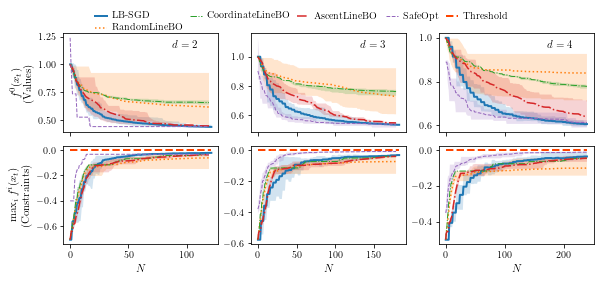

In [312]:
problem_name = 'QP'
experiments_num = 10

d = 2
def fq2(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
    return np.linalg.norm(x - xx, 2)**2 / 4. / d
d = 3
def fq3(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
    return np.linalg.norm(x - xx, 2)**2 / 4. / d
d = 4
def fq4(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
    return np.linalg.norm(x - xx, 2)**2 / 4. / d


fig, axes = plt.subplots(nrows=2, ncols=3, 
                         figsize=(1.3 * 6.5, 1.3 * 0.33 * 8.5), 
                         constrained_layout=False, 
                         sharex='col')
for d, axes_col, f, x_opt in zip([2,3,4], axes.T, 
                                 [fq2, fq3, fq4], 
                                 [np.ones(2) / 2**0.5, 
                                  np.ones(3) / 3**0.5, 
                                  np.ones(4) / 4**0.5 ]):
    plot_experiments_linebo(d, axes_col, problem_name, experiments_num, f,
                            SafeOpt = True, 
                            opt_val = f(x_opt))

handles = axes[1, 0].get_legend_handles_labels()
leg = fig.legend(*handles, loc='center',
                 bbox_to_anchor=(0.5, 1.), ncol=5, frameon=False, fontsize=10, numpoints=1,
                 labelspacing=0.2, columnspacing=0.8, handlelength=1.2, handletextpad=0.5)
fig.tight_layout(h_pad=1., w_pad=0.5)
artist_to_keep = [leg]
plt.savefig('../plots/plot_comparison_' + problem_name + '.pdf', 
            bbox_extra_artists=artist_to_keep, bbox_inches='tight')

## Comparing LB-SGD, SafeOpt, and LineBO on the Rosenbrock objective and quadratic constraints (Section 5.1.2)

### $d = 2$

In [305]:
"""
Rosenbrock benchmark function with quadratic constraints.
"""

d = 2
m = 2
experiments_num = 10
n_iters = 100
n = 2
problem_name = 'Rosenbrock'

M0 = 60.
Ms = 10. * np.ones(m)
x00 = -0.05 * np.ones(d)
x_opt = np.ones(d)
sigma = 0.001
nu = 0.01
L = 0.1
T = 6

def f(x):
    return (100. * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2).sum()

def h(x):
    h1 = np.linalg.norm(x,2)**2 - 1.
    h2 = np.linalg.norm(x + 0.1 * np.ones(d),2)**2 - 2. * 0.1
    return np.array([h1, h2]) 

In [306]:
_ = run_exp_SafeOpt(f, h, d, m,
                    experiments_num=experiments_num, 
                    n_iters=n_iters,  
                    x00=x00, 
                    x_opt=x_opt,  
                    sigma=sigma,
                    problem_name=problem_name,
                    bnd_l=-0.5, bnd_u=0.5,
                    L=L,
                    gp_num_samples=100,
                    gp_var=10.,
                    gp_var_cons=1.,
                    method = 'SOS'
                   )

SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


In [299]:
_ = run_exp_LB_SGD(f, h, d, m,
                   experiments_num = experiments_num, 
                   n_iters = n_iters,
                   n = n, 
                   M0 = M0, 
                   Ms = Ms, 
                   x00 = x00,
                   x_opt = x_opt, 
                   init_std = 0.,
                   factor = 0.7,
                   eta0 = 0.1,
                   T = T,
                   sigma=sigma,
                   problem_name=problem_name)

LB_SGD runs finished


### $d = 3$

In [300]:
d = 3
m = 2
experiments_num = 10
n_iters = 150
n = 3
problem_name = 'Rosenbrock'
M0 = 50.
Ms = 10. * np.ones(m)
x00 = -0.05 * np.ones(d)
x_opt = np.ones(d)
sigma = 0.001
nu = 0.01

def f(x):
    f_rosenbrock = 0.
    for i in range(d - 1):
        f_rosenbrock += 100. * (x[i + 1] - x[i]**2)**2 + (1. - x[i])**2
    return f_rosenbrock

def h(x):
    h1 = np.linalg.norm(x,2)**2 - 1.
    h2 = np.linalg.norm(x + 0.1 * np.ones(d),2)**2 - 2. * 0.1
    return np.array([h1, h2])

In [254]:
_ = run_exp_SafeOpt(f, h, d, m,
                    experiments_num = experiments_num, 
                    n_iters = n_iters,  
                    x00 = x00, 
                    bnd_l=-1., bnd_u=1.,
                    L=L,
                    gp_num_samples=100,
                    gp_var=10.,
                    gp_var_cons=1.,
                    x_opt = x_opt,  
                    sigma = sigma,
                    problem_name = problem_name)

SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


In [301]:
_ = run_exp_LB_SGD(f, h, d, m,
                   experiments_num = experiments_num, 
                   n_iters = n_iters,
                   n = n, 
                   M0 = M0, 
                   Ms = Ms, 
                   x00 = x00,
                   init_std = 0.,
                   factor = 0.7,
                   eta0 = 0.1,
                   T = T,
                   x_opt = x_opt, 
                   sigma = sigma,
                   problem_name = problem_name)

LB_SGD runs finished


### $d = 4$

In [302]:
d = 4
m = 2
experiments_num = 10
n_iters = 200
n = 4
problem_name = 'Rosenbrock'
bnd = 1.
M0 = 60.
Ms = 10. * np.ones(m)
x00 = -0.05 * np.ones(d)
x_opt = np.ones(d)
sigma = 0.001
nu = 0.01

def f(x):
    f_rosenbrock = 0.
    for i in range(d - 1):
        f_rosenbrock += 100. * (x[i + 1] - x[i]**2)**2 + (1. - x[i])**2
    return f_rosenbrock

def h(x):
    h1 = np.linalg.norm(x,2)**2 - 1.
    h2 = np.linalg.norm(x + 0.1 * np.ones(d),2)**2 - 2. * 0.1
    return np.array([h1, h2]) 

In [257]:
_ = run_exp_SafeOpt(f, h, d, m,
                    experiments_num = experiments_num, 
                    n_iters = n_iters,  
                    x00 = x00, 
                    bnd_l=-1., bnd_u=1.,
                    L=L,
                    gp_num_samples=100,
                    gp_var=10.,
                    gp_var_cons=1.,
                    x_opt = x_opt,  
                    sigma = sigma,
                    problem_name = problem_name)

SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


In [303]:
_ = run_exp_LB_SGD(f, h, d, m,
                   experiments_num = experiments_num, 
                   n_iters = n_iters,
                   n = n, 
                   M0 = M0, 
                   Ms = Ms, 
                   x00 = x00, 
                   x_opt = x_opt,
                   factor = 0.7,
                   eta0 = 0.1,
                   T = T,
                   sigma = sigma,
                   init_std = 0.,
                   problem_name = problem_name)

LB_SGD runs finished


### Plot the results

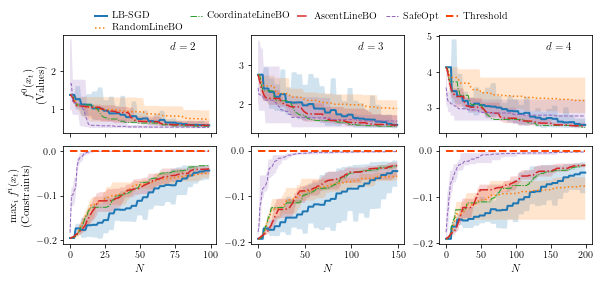

In [313]:
problem_name = 'Rosenbrock'
experiments_num = 10

d = 2
def fr2(x):
    f_rosenbrock = 0.
    for i in range(d - 1):
        f_rosenbrock += 100. * (x[i + 1] - x[i]**2)**2 + (1. - x[i])**2
    return f_rosenbrock
d = 3
def fr3(x):
    f_rosenbrock = 0.
    for i in range(d - 1):
        f_rosenbrock += 100. * (x[i + 1] - x[i]**2)**2 + (1. - x[i])**2
    return f_rosenbrock
d = 4
def fr4(x):
    f_rosenbrock = 0.
    for i in range(d - 1):
        f_rosenbrock += 100. * (x[i + 1] - x[i]**2)**2 + (1. - x[i])**2
    return f_rosenbrock

fig, axes = plt.subplots(nrows=2, ncols=3, 
                         figsize=(1.3 * 6.5, 1.3 * 0.33 * 8.5), 
                         constrained_layout=False, 
                         sharex='col')
for d, axes_col, f, x_opt in zip([2,3,4], axes.T, 
                                 [fr2, fr3, fr4], 
                                 [np.ones(2), 
                                  np.ones(3), 
                                  np.ones(4)]):
    plot_experiments_linebo(d, axes_col, problem_name, experiments_num, f,
                            SafeOpt = True, opt_val = f(x_opt))

handles = axes[1, 0].get_legend_handles_labels()
leg = fig.legend(*handles, loc='center',
                 bbox_to_anchor=(0.5, 1.), ncol=5, frameon=False, fontsize=10, numpoints=1,
                 labelspacing=0.2, columnspacing=0.8, handlelength=1.2, handletextpad=0.5)
fig.tight_layout(h_pad=1., w_pad=0.5)
artist_to_keep = [leg]
plt.savefig('../plots/plot_comparison_' + problem_name + '.pdf', 
            bbox_extra_artists=artist_to_keep, bbox_inches='tight')

### Runtimes comparison for QP and Rosenbrock

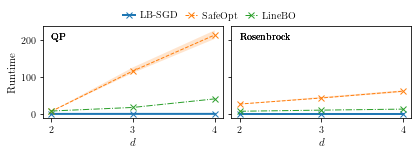

In [314]:
experiments_num = 10
ds = range(2,5)
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(1.3 * 0.7 * 6.5, 1.3 * 0.18 * 8.5), 
                         constrained_layout=False, 
                         sharey='row', 
                         sharex='col')
for problem_name, axes_col in zip(['QP', 'Rosenbrock'], axes.T):
    plot_runtimes(axes_col, problem_name, experiments_num, ds)
handles = axes[0].get_legend_handles_labels()
leg = fig.legend(*handles, loc='center',
                 bbox_to_anchor=(0.5, 1.), ncol=5, frameon=False, fontsize=10, numpoints=1,
                 labelspacing=0.2, columnspacing=0.8, handlelength=1.2, handletextpad=0.5)
fig.tight_layout(h_pad=1., w_pad=0.5)
artist_to_keep = [leg]
plt.savefig('../plots/plot_runtimes_QP_Rosenbrock' + '.pdf', 
            bbox_extra_artists=artist_to_keep, bbox_inches='tight')

## Comparing LB-SGD, SafeOpt, and LineBO on the  negative Gaussian objective and quadratic constraint (Section 5.1.3)

### $d = 2$

In [16]:
d = 2
m = 1
experiments_num = 10
n_iters = 300
x_opt = np.zeros(d) / d**0.5
x00 = d**(-0.5) * np.ones(d)
sigma = 0.001
nu = 0.01
L = d


n = int(d / 2)
M0 = 20.
Ms = d * 0.5 * np.ones(m)
T = 3
problem_name = 'Gaussian'

"""
Gaussian benchmark function with quadratic constraint.
"""

def h(X):
    r = 0.5
    x0 = d**(-0.5) * np.ones(d)
    h = 0.2 * np.linalg.norm(X - x0)**2 - r**2 + 10. * (X[1] - x0[1])**2
    return h
 
def f(X):
    Y = np.exp(-4. * np.linalg.norm(X,2)**2)
    return -Y


In [104]:
_ = run_exp_LB_SGD(f, h, d, m,
                   experiments_num = experiments_num, 
                   n_iters = n_iters,
                   n = n, 
                   M0 = M0, 
                   Ms = Ms, 
                   x00 = x00, 
                   init_std = 0.,
                   eta0 = 0.1, 
                   factor = 0.95,
                   x_opt = x_opt, 
                   sigma = sigma,
                   problem_name = problem_name)

LB_SGD runs finished


### $d = 10$

In [106]:
d = 10
m = 1
experiments_num = 10
n_iters = d * 100
x_opt = np.zeros(d) / d**0.5
x00 = d**(-0.5) * np.ones(d)
sigma = 0.001
nu = 0.01
L = d

n = int(d / 3)
M0 = 30.
Ms = d * 0.5 * np.ones(m)
T = 3
problem_name = 'Gaussian'

"""
Gaussian benchmark function with quadratic constraint.
"""

def h(X):
    r = 0.5
    x0 = d**(-0.5) * np.ones(d)
    h = 0.2 * np.linalg.norm(X - x0)**2 - r**2 + 10. * (X[1] - x0[1])**2
    return h
 
def f(X):
    Y = np.exp(-4. * np.linalg.norm(X,2)**2)
    return -Y

In [107]:
_ = run_exp_LB_SGD(f, h, d, m,
                   experiments_num = experiments_num, 
                   n_iters = n_iters,
                   n = n, 
                   M0 = M0, 
                   Ms = Ms, 
                   x00 = x00,
                   eta0 = 0.1,
                   init_std = 0., 
                   factor = 0.95,
                   x_opt = x_opt, 
                   sigma = sigma,
                   problem_name = problem_name)

LB_SGD runs finished


### $d = 20$

In [110]:
d = 20
m = 1
experiments_num = 10
n_iters = 1500
x_opt = np.zeros(d) / d**0.5
x00 = d**(-0.5) * np.ones(d)
sigma = 0.001
nu = 0.01
L = d

n = int(d / 3)
M0 = 30.
Ms = d * 0.5 * np.ones(m)
T = 3
problem_name = 'Gaussian'

"""
Gaussian benchmark function with quadratic constraint.
"""

def h(X):
    r = 0.5
    x0 = d**(-0.5) * np.ones(d)
    h = 0.2 * np.linalg.norm(X - x0)**2 - r**2 + 10. * (X[1] - x0[1])**2
    return h
 
def f(X):
    Y = np.exp(-4. * np.linalg.norm(X,2)**2)
    return -Y

In [111]:
_ = run_exp_LB_SGD(f, h, d, m,
                   experiments_num = experiments_num, 
                   n_iters = n_iters,
                   n = n, 
                   M0 = M0, 
                   Ms = Ms, 
                   x00 = x00,
                   eta0 = 0.1,
                   init_std = 0., 
                   factor = 0.95,
                   x_opt = x_opt, 
                   sigma = sigma,
                   problem_name = problem_name)

LB_SGD runs finished


### Plot the results

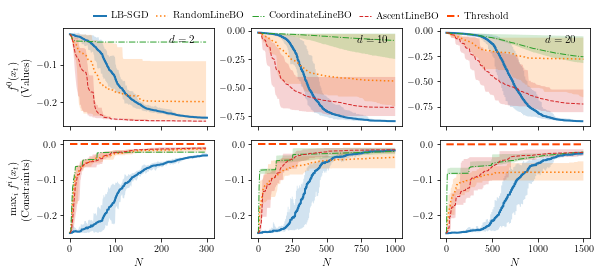

In [315]:
problem_name = 'Gaussian'
experiments_num = 10

d = 2
def f2(X):
    Y = np.exp(-4. * np.linalg.norm(X,2)**2)
    return -Y
d = 10
def f10(X):
    Y = np.exp(-4. * np.linalg.norm(X,2)**2)
    return -Y
d = 20
def f20(X):
    Y = np.exp(-4. * np.linalg.norm(X,2)**2)
    return -Y

fig, axes = plt.subplots(nrows=2, ncols=3, 
                         figsize=(1.3 * 6.5, 1.3 * 0.33 * 8.5), 
                         constrained_layout=False, 
                         sharex='col')

for d, axes_col, f in zip([2, 10, 20], axes.T, [f2, f10, f20]):
    plot_experiments_linebo(d, axes_col, problem_name, experiments_num, f,
                            SafeOpt = False, opt_val = -1.)
handles = axes[1, 0].get_legend_handles_labels()
leg = fig.legend(*handles, loc='center',
                 bbox_to_anchor=(0.5, 1.), ncol=5, frameon=False, fontsize=10, numpoints=1,
                 labelspacing=0.2, columnspacing=0.8, handlelength=1.2, handletextpad=0.5)
fig.tight_layout(h_pad=1., w_pad=0.5)
artist_to_keep = [leg]
plt.savefig('../plots/plot_comparison_' + problem_name + '.pdf', 
            bbox_extra_artists=artist_to_keep, bbox_inches='tight')

### Show the average runtimes of LB_SGD

In [65]:
for d in [2, 10, 20]:
    with open('../runs/LB_SGD_' + problem_name + '_d' + str(d) + '.npy', 'rb') as file:
        LB_errors = np.load(file)
        LB_cons = np.load(file) 
        LB_times = np.load(file)
    LB_t_avg = np.mean(LB_times, axis=0)
    print('d=', d,':', LB_t_avg ,'; ')

d= 2 : 0.8079489707946778 ; 
d= 10 : 2.2456504821777346 ; 
d= 20 : 3.010275363922119 ; 


## Case of Gaussian objective and quadratic constraint that does not influence the solution

### $d = 2$

In [66]:
d = 2
m = 2
experiments_num = 10
n_iters = 150
x_opt = np.zeros(d) / d**0.5
x00 = d**(-0.5) * np.ones(d)
L = d

n = int(d / 2)
M0 = 20.
Ms = d**2 * 0.5 * np.ones(m)
T = 3
problem_name = 'GaussianUn'

"""
Gaussian benchmark function with big quadratic constraint set such that the solution is in the interior.
"""
def f(X):
    Y = np.exp(-4 * np.linalg.norm(X,2)**2)
    return -Y

def h(X):
    r = 10.
    x0 = d**(-0.5) * np.ones(d)
    h = 0.2 * np.linalg.norm(X - x0)**2 - r**2 + 10. * (X[1] - x0[1])**2
    f_val = f(X)
    return h

In [67]:
_ = run_exp_LB_SGD(f, h, d, m,
                   experiments_num = experiments_num, 
                   n_iters = n_iters,
                   n = n, 
                   M0 = M0, 
                   Ms = Ms, 
                   x00 = x00, 
                   init_std = 0.,
                   eta0 = 0.05, 
                   factor = 0.85,
                   x_opt = x_opt, 
                   sigma = sigma,
                   problem_name = problem_name)

LB_SGD runs finished


### $d = 10$

In [68]:
d = 10
m = 1 
experiments_num = 10
n_iters = 700
x_opt = np.zeros(d) / d**0.5
x00 = d**(-0.5) * np.ones(d)

n = int(d / 2)
M0 = 20.
Ms = d**2 * 0.5 * np.ones(m)
T = 3
problem_name = 'GaussianUn'


def f(X):
    Y = np.exp(-4 * np.linalg.norm(X,2)**2)
    return -Y

def h(X):
    r = 10.
    x0 = d**(-0.5) * np.ones(d)
    h = 0.2 * np.linalg.norm(X - x0)**2 - r**2 + 10. * (X[1] - x0[1])**2
    f_val = f(X)
    return h

In [69]:
_ = run_exp_LB_SGD(f, h, d, m,
                   experiments_num = experiments_num, 
                   n_iters = n_iters,
                   n = n, 
                   M0 = M0, 
                   Ms = Ms, 
                   x00 = x00, 
                   init_std = 0.,
                   eta0 = 0.05, 
                   factor = 0.9,
                   x_opt = x_opt, 
                   sigma = sigma,
                   problem_name = problem_name)

LB_SGD runs finished


### $d = 20$

In [70]:
d = 20
m = 2 
experiments_num = 10
n_iters = 1000
x_opt = np.zeros(d) / d**0.5
x00 = d**(-0.5) * np.ones(d)

n = int(d / 2)
M0 = 20.
Ms = d**2 * 0.5 * np.ones(m)
T = 3
problem_name = 'GaussianUn'

def f(X):
    Y = np.exp(-4 * np.linalg.norm(X,2)**2)
    return -Y

def h(X):
    r = 10.
    x0 = d**(-0.5) * np.ones(d)
    h = 0.2 * np.linalg.norm(X - x0)**2 - r**2 + 10. * (X[1] - x0[1])**2
    f_val = f(X)
    return h

In [71]:
_ = run_exp_LB_SGD(f, h, d, m,
                   experiments_num = experiments_num, 
                   n_iters = n_iters,
                   n = n, 
                   M0 = M0, 
                   Ms = Ms, 
                   x00 = x00, 
                   init_std = 0.,
                   eta0 = 0.005, 
                   factor = 0.9,
                   x_opt = x_opt, 
                   sigma = sigma,
                   problem_name = problem_name)

LB_SGD runs finished


### Plot the results

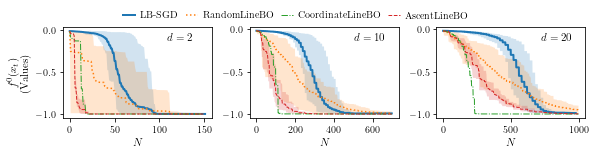

In [316]:
problem_name = 'GaussianUn'
experiments_num = 10

d = 2
def f2(X):
    Y = np.exp(-4. * np.linalg.norm(X,2)**2)
    return -Y
d = 10
def f10(X):
    Y = np.exp(-4. * np.linalg.norm(X,2)**2)
    return -Y
d = 20
def f20(X):
    Y = np.exp(-4. * np.linalg.norm(X,2)**2)
    return -Y

fig, axes = plt.subplots(nrows=1, ncols=3, 
                         figsize=(1.3 * 6.5, 1.3 * 0.18 * 8.5), 
                         constrained_layout=False,  
                         sharex='col')

for d, axes_col, f in zip([2, 10, 20], axes.T, [f2, f10, f20]):
    plot_experiments_linebo(d, axes_col, problem_name, experiments_num, f,
                            SafeOpt = False, opt_val = -1., cons = False)
    
handles = axes[0].get_legend_handles_labels()
leg = fig.legend(*handles, loc='center',
                 bbox_to_anchor=(0.5, 1.), ncol=5, frameon=False, fontsize=10, numpoints=1,
                 labelspacing=0.2, columnspacing=0.8, handlelength=1.2, handletextpad=0.5)
fig.tight_layout(h_pad=1., w_pad=0.5)
artist_to_keep = [leg]
plt.savefig('../plots/plot_comparison_' + problem_name + '.pdf', 
            bbox_extra_artists=artist_to_keep, bbox_inches='tight')